In [9]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Preprocessing

In [10]:
# def preprocess_image(image_path, size=(224, 224)):
#     img = Image.open(image_path)
    
#     # Quality enhancement
#     enhancer = ImageEnhance.Sharpness(img)
#     img = enhancer.enhance(2.0)  # Increase sharpness
    
#     # Noise reduction
#     image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#     image = cv2.GaussianBlur(image, (5, 5), 0)
#     img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
#     # Consistency
#     img = img.resize(size, Image.LANCZOS)
    
#     # Normalization
#     img_array = np.array(img) / 255.0
    
#     # Convert back to image
#     img = Image.fromarray((img_array * 255).astype(np.uint8))
    
#     return img

# # Apply preprocessing and save to new directory
# input_dir = 'data/images_train_test_val/train'
# output_dir = 'data/processed_images'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for category in os.listdir(input_dir):
#     category_path = os.path.join(input_dir, category)
#     if os.path.isdir(category_path):
#         output_category_path = os.path.join(output_dir, category)
#         if not os.path.exists(output_category_path):
#             os.makedirs(output_category_path)
#         for image_name in os.listdir(category_path):
#             image_path = os.path.join(category_path, image_name)
#             preprocessed_img = preprocess_image(image_path)
#             preprocessed_img.save(os.path.join(output_category_path, image_name))

Check Image Corruption

In [11]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


Train/Test Split

In [12]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [13]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    #
    model.add(SeparableConv2D(32, 3, activation="relu", input_shape=(226, 226, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2)))

    model.add(SeparableConv2D(64, 3, activation="relu"))
    model.add(SeparableConv2D(128, (3, 3), activation="relu"))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2)))

    model.add(SeparableConv2D(128, 3, activation="relu"))
    model.add(SeparableConv2D(128, 3, activation="relu"))
    model.add(Dropout(0.5))
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation="softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = create_model()

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
    # model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    # model.add(Dropout(0.5))
    # model.add(Dense(21, activation='softmax'))

Model Creation

In [14]:
# Define a checkpoint callback
checkpoint = ModelCheckpoint(
    'models/best_CNN_model.keras',  
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1 
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
    )

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]  # include both callbacks here
)

Epoch 1/20


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0569 - loss: 3.0335
Epoch 1: val_accuracy improved from -inf to 0.04905, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1693s 15s/step - accuracy: 0.0569 - loss: 3.0332 - val_accuracy: 0.0490 - val_loss: 3.0438 - learning_rate: 0.0010
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.1106 - loss: 2.9049 
Epoch 2: val_accuracy improved from 0.04905 to 0.08571, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 9483s 83s/step - accuracy: 0.1107 - loss: 2.9044 - val_accuracy: 0.0857 - val_loss: 2.9917 - learning_rate: 0.0010
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1741 - loss: 2.7083 
Epoch 3: val_accuracy improved from 0.08571 to 0.17714, saving model to models/best_CNN_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 1540s 13s/step - accuracy: 0.1741 - loss: 2.7082 - val_accuracy: 0.1771 - val_loss: 2.8717 - learning_rate: 0.0010
Epoch 4/20
115/115 ━━━━

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 370ms/step - accuracy: 0.6656 - loss: 1.1372
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.5194 - loss: 1.5401
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.5319 - loss: 1.5181
Train accuracy: 0.6597, Validation accuracy: 0.5271, Test accuracy: 0.5238


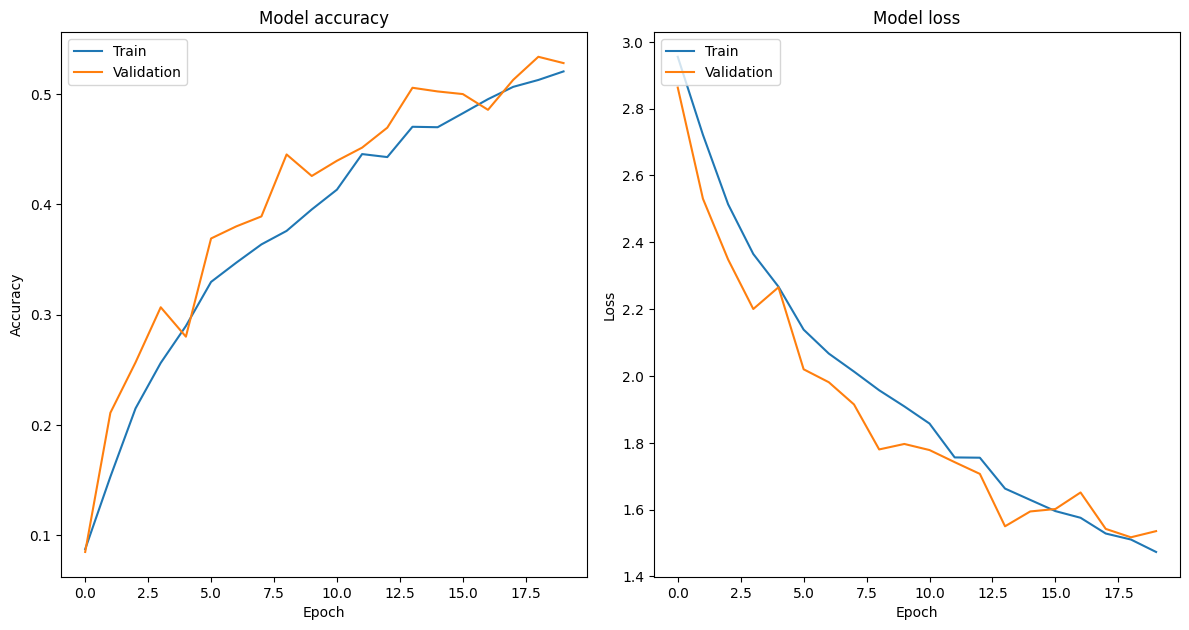

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-25 08:18:31.204264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 729ms/step


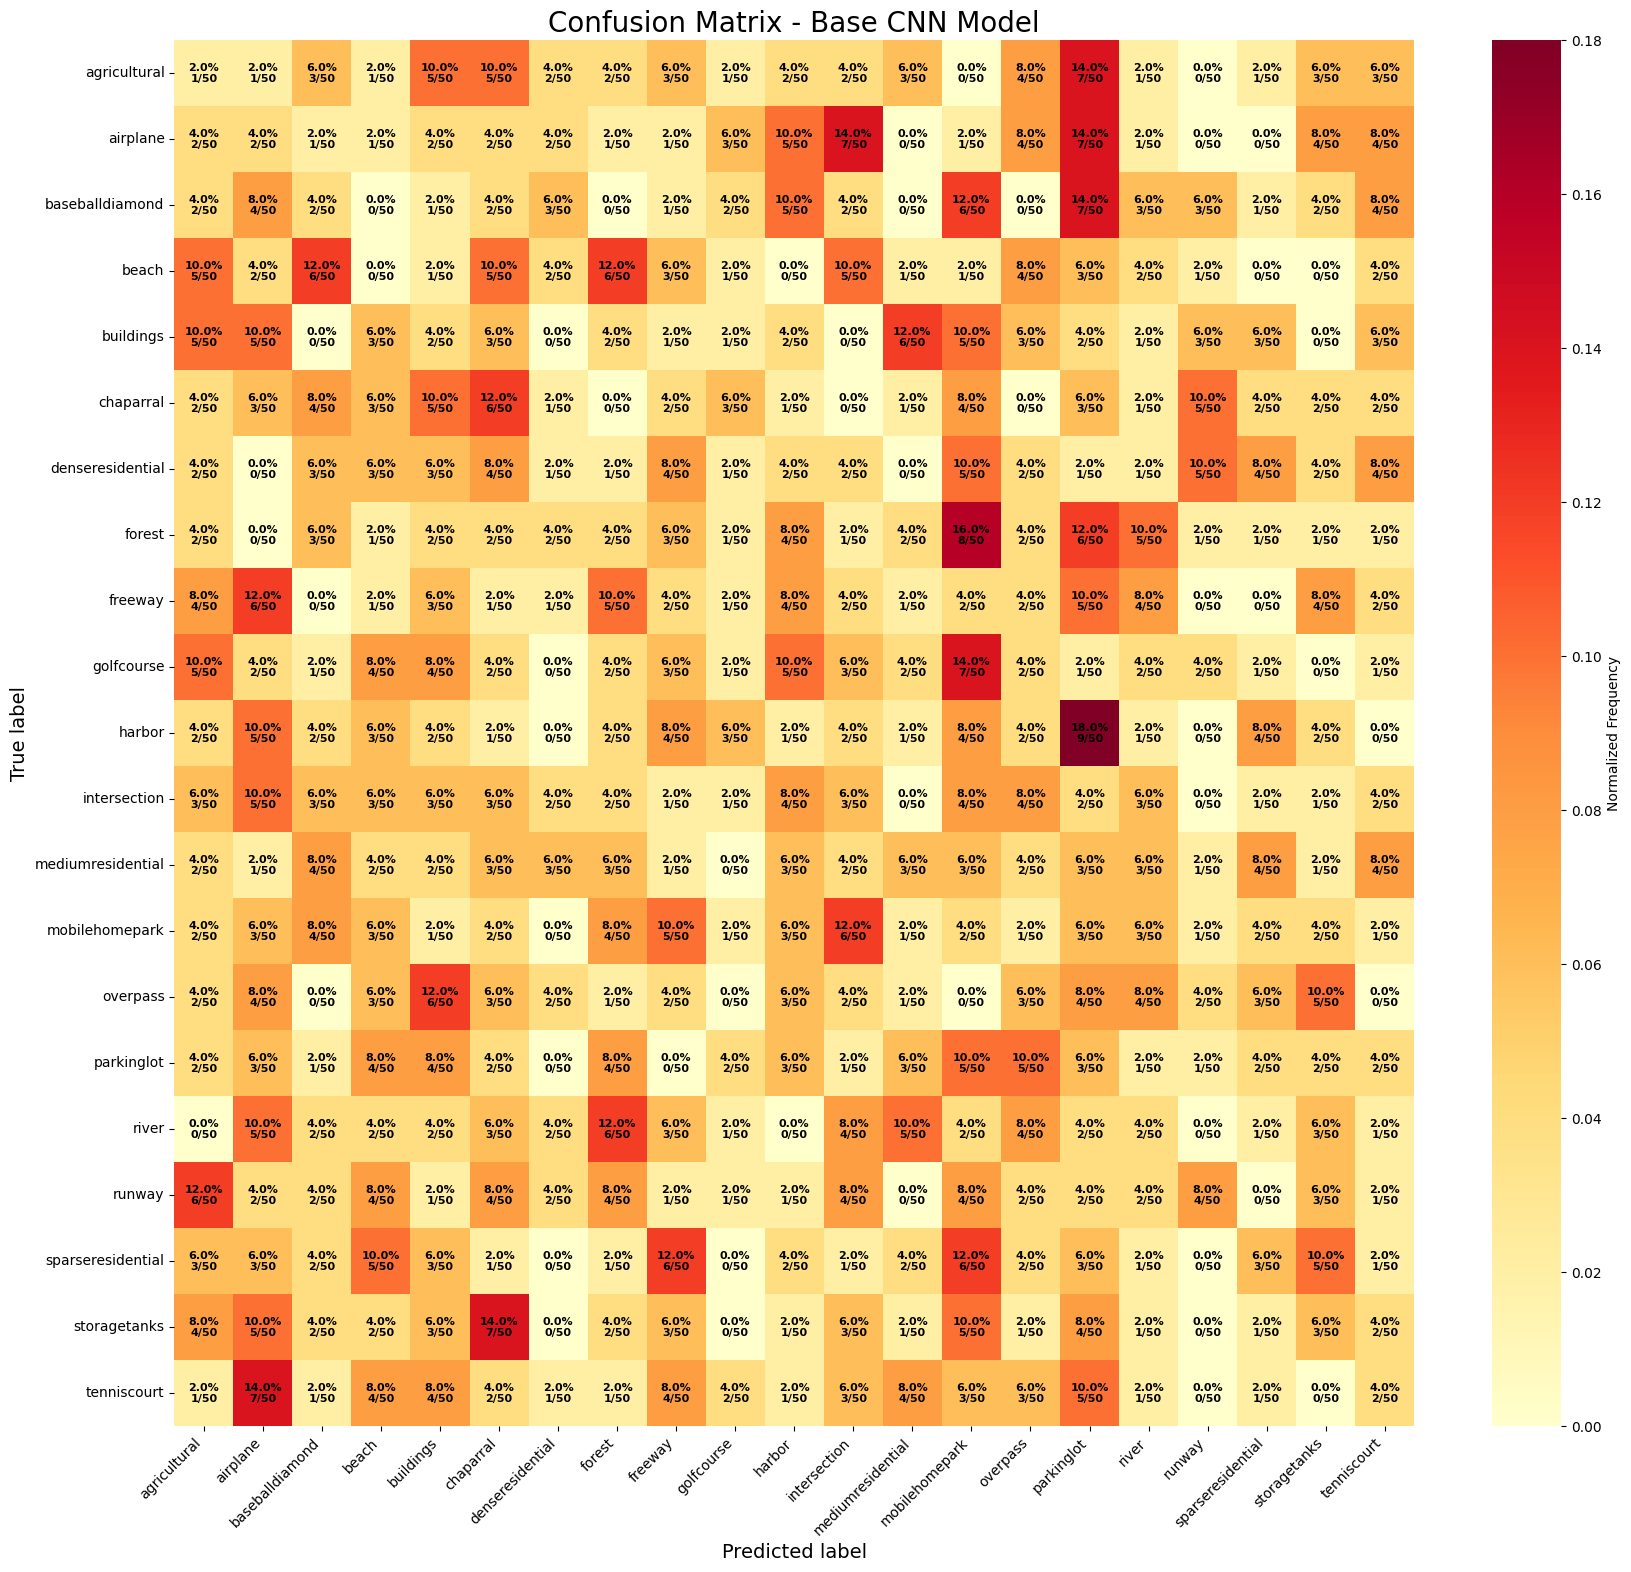

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_CNN_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - Base CNN Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.show()